In [1]:
#https://www.macroption.com/historical-volatility-calculation/
import warnings
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import time
import json
import math
import calendar
import requests
from datetime import timedelta, datetime, date
from iexfinance.stocks import Stock, get_historical_data
from iexfinance import get_stats_recent
from fredapi import Fred
from pytradier import *
import matplotlib.tri as mtri
%matplotlib inline
%load_ext autoreload
%autoreload 2
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

In [303]:
#FRED 
api_fred = '6c1cfcd9d73bfc9aadf90a70504aea70'
tradier = Tradier("Bearer YAmPl8F7M7iAumb7kSeuDYXYdKpw")
plotly.tools.set_credentials_file(username='jaisal1024', api_key='zs2dYHFw3lfS6AXm1zM9')
plotly.tools.set_config_file(world_readable=True,
                             sharing='public')
fred = Fred(api_key=api_fred)

In [6]:
portfolio = ['MSFT', 'BA', 'AAPL', 'V', 'GOOGL', 'SPY']
stocks = Stock(portfolio)
p = stocks.get_price()
c = calendar.Calendar(firstweekday=calendar.SATURDAY)
options_dates = [1, 3, 6, 9]

In [7]:
d = timedelta(days = 61)
yest = timedelta(days = 1)
start = date.today()-d
end = date.today()-yest
historicals = get_historical_data(portfolio, start, end, output_format='pandas').reset_index()
dates = historicals['date']

In [298]:
#Candlestick Graph
df = historicals[portfolio[0]].join(dates)
trace = go.Ohlc(x=df['date'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])
data = [trace]
py.iplot(data, filename='simple_candlestick')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~jaisal1024/0 or inside your plot.ly account where it is named 'simple_candlestick'


In [8]:
## calculate volatility using 1-day high-low movements, for 3 month periods, annualized 
def hv_1(historicals): 
    df = {}
    for stock in portfolio: 
        sigmas = {}
        h = historicals[stock].join(dates)
        i = timedelta(days = 31)
        j = 1
        while(i+dates[j] <= dates[len(dates)-1]):
            h1 = h[(h['date'] >= dates[j-1]) & (h['date'] <= i+dates[j])]  
            h1['volatility'] = h1['close'].pct_change()
            h1[1:]
            sigma_matrix = np.std(h1['volatility'])* np.sqrt(252)
            sigmas[i+dates[j]] = sigma_matrix
            j+=1
        df[stock] = sigmas
    return pd.DataFrame(df)

def hv_2(historicals): 
    df = {}
    for stock in portfolio: 
        sigmas = {}
        h = historicals[stock].join(dates)
        i = timedelta(days = 31)
        j = 1
        while(i+dates[j] <= dates[len(dates)-1]):
            h1 = h[(h['date'] >= dates[j-1]) & (h['date'] <= i+dates[j])] 
            h1['volatility'] = np.log(h1['close'].shift(1)/h1['close'])
            h1[1:]
            sigma_matrix = np.std(h1['volatility'])* np.sqrt(252)
            sigmas[i+dates[j]] = sigma_matrix
            j+=1
        df[stock] = sigmas
    return pd.DataFrame(df)

def hv_weighted(historicals,  weight): 
    df = {}
    for stock in portfolio: 
        sigmas = {}
        h = historicals[stock].join(dates)
        i = timedelta(days = 31)
        j = 1
        while(i+dates[j] <= dates[len(dates)-1]):
            h1 = h[(h['date'] >= dates[j]) & (h['date'] <= i+dates[j])]  
            h1['volatility'] = np.log(h1['close']/h1['open'])*weight + np.log(h1['high']/h1['low'])*(1-weight)
            sigma_matrix = np.std(h1['volatility'])* np.sqrt(252)
            sigmas[i+dates[j]] = sigma_matrix
            j+=1
        df[stock] = sigmas
    return pd.DataFrame(df)

def hv_hl(historicals): 
    df = {}
    for stock in portfolio: 
        sigmas = {}
        h = historicals[stock].join(dates)
        i = timedelta(days = 31)
        j = 1
        while(i+dates[j] <= dates[len(dates)-1]):
            h1 = h[(h['date'] >= dates[j]) & (h['date'] <= i+dates[j])]  
            h1['volatility'] = np.log(h1['high']/h1['low'])
            h1['volatility'] = h1['volatility'].apply(lambda x: 1/(4*np.log(2))*x**2)
            sigma_matrix = np.sqrt(np.sum(h1['volatility'])/len(h1.index)*252)
            sigmas[i+dates[j]] = sigma_matrix
            j+=1
        df[stock] = sigmas
    return pd.DataFrame(df)

def hv_all(stock, hv_1, hv_2, hv_weighted, hv_hl): 
    hv_all_ = [pd.DataFrame(hv_1[stock].rename("HV Pct", axis = 'columns'))]
    hv_all_.append(pd.DataFrame(hv_2[stock].rename("HV Log", axis = 'columns')))
    hv_all_.append(pd.DataFrame(hv_weighted[stock].rename("HV Weighted", axis = 'columns')))
    hv_all_.append(pd.DataFrame(hv_hl[stock].rename("HV HL", axis = 'columns')))
    return pd.concat(hv_all_, axis = 1)
        
        

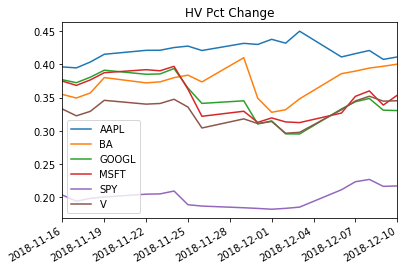

In [9]:
hv_1_df_ = hv_1(historicals)
hv_1_df_.plot(title = 'HV Pct Change')

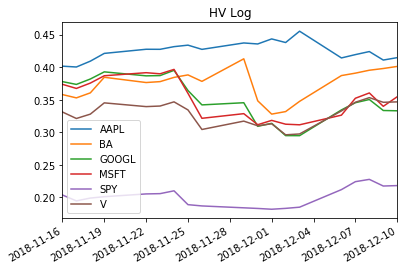

In [10]:
hv_2_df_ = hv_2(historicals)
hv_2_df_.plot(title = 'HV Log')

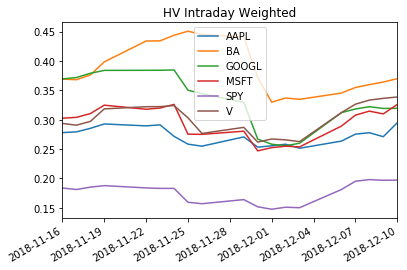

In [11]:
hv_weighted_df_ = hv_weighted(historicals, 1)
hv_weighted_df_.plot(title = 'HV Intraday Weighted')

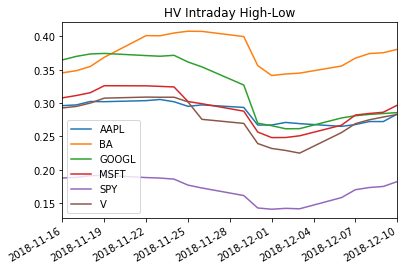

In [12]:
hv_hl_df_ = hv_hl(historicals)
hv_hl_df_.plot(title = 'HV Intraday High-Low')

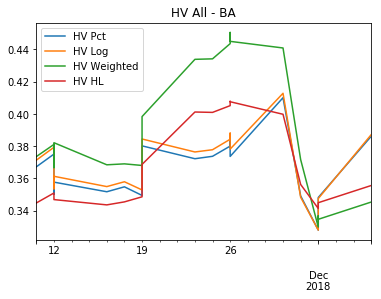

In [103]:
hv_all_ = hv_all('BA', hv_1_df_, hv_2_df_, hv_weighted_df_, hv_hl_df_)
hv_all_.plot(title = 'HV All - BA')

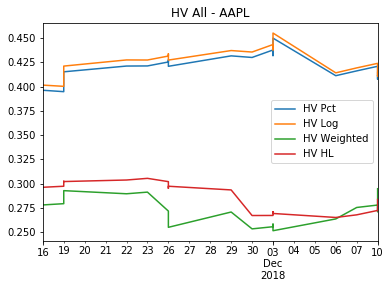

In [13]:
hv_all_ = hv_all('AAPL', hv_1_df_, hv_2_df_, hv_weighted_df_, hv_hl_df_)
hv_all_.plot(title = 'HV All - AAPL')

In [119]:
def M_(c, default, beta, t):
    x = c*beta*np.sqrt(t)/default
    return x/(1+abs(x))+1
def call_(s, x, t, r, q, d1, d2): 
    return s*math.exp(-q*t)*norm.cdf(d1)-x*math.exp(-r*t)*norm.cdf(d2)
def put_(s, x, t, r, q, d1, d2):
    return x*math.exp(-r*t)*(1-norm.cdf(d2)) - s*math.exp(-q*t)*(1-norm.cdf(d1))
def d1_(s, x, t, r, q, sigma): 
    return (np.log(s/x)+(r-q+(np.power(sigma,2)/2)*t)) / (sigma*np.sqrt(t))
def d2_(d1, sigma, t):
    return d1 - sigma*np.sqrt(t)
def third_friday(month, year): 
    monthcal = c.monthdatescalendar(year, month)
    return monthcal[2][-1]
def generate_times(start, year): 
    t = []
    for i in range(6):
        if (i < 3): 
            t.append(third_friday(options_dates[(start+i)%len(options_dates)], (year + int((start+i)/len(options_dates))))) 
        else: 
            t.append(third_friday(options_dates[(start+i+(i-2))%len(options_dates)], (year + int((start+i+(i-2))/len(options_dates)))))
    return t
def t_(today):
    t = []
    month = int(today.month-1 + today.day/third_friday(today.month, today.year).day) % 12
    if (month > 9):
        t = generate_times(0, today.year+1)
    elif (month > 6): 
        t = generate_times(3, today.year)
    elif (month > 3): 
        t = generate_times(2, today.year)
    else: 
        t = generate_times(1, today.year)
    return t
def strikes_(s, num):
    strikes = {}
    for ticker in s:
        if (s[ticker]>300): 
            strikes[ticker] = [((round(s[ticker],-1))+((i-num)*10)) for i in range(2*num)]
        else: 
            strikes[ticker] = [((round(s[ticker],-1))+((i-num)*5)) for i in range(2*num)]
    return strikes
def extractQ(p): 
    q_dict = stocks.get_dividends(range = '1y', filter = 'amount')
    q = {}
    for q_s in q_dict:
        sum_ =0
        if (q_dict[q_s]):
            for a in q_dict[q_s]: 
                sum_+= a['amount']
        q[q_s] = sum_/p[q_s]
    return q

In [286]:
def graph_option_1(chain, stock):
    chain_ = chain.loc[chain['Stock'] == stock]
    fig = plt.figure()
    ax = Axes3D(fig)
    Axes3D.mouse_init(ax)
    surf = ax.plot_trisurf(chain_["Strike"], chain_["T"], chain_["Call Premium"], cmap=cm.RdBu, linewidth=0.5, antialiased=False)
    ax.set_title('3-D Options Surface for '+ stock)
    # fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


def graph_option_subplot(chain, chain_2, stock, stock_2 = None): 
    if (stock_2 == None): 
        stock_2 = stock
    chain_ = chain.loc[chain['Stock'] == stock]
    chain_2 = chain.loc[chain['Stock'] == stock_2]
    
    x = chain_["Strike"]
    y = chain_["T"]
    tri = mtri.Triangulation(x, y)
    
    fig = plt.figure(figsize=plt.figaspect(0.25))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    surf = ax.plot_trisurf(x,y, chain_["Call Premium"], triangles=tri.triangles, cmap=plt.cm.CMRmap,linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.75, aspect=10)
    
    x1 = chain_2["Strike"]
    y1 = chain_2["T"]
    tri = mtri.Triangulation(x1, y1)
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax.plot_trisurf(x1, y1, chain_2["Spread"], triangles=tri.triangles, cmap=plt.cm.Spectral,linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.75, aspect=10)

    plt.show()
    
def graph_real_option_subplot(chain, stock): 
    chain_ = chain.loc[((chain['underlying'] == stock) & (chain['option_type'] == 'call'))]
    chain_2 = chain.loc[((chain['underlying'] == stock) & (chain['option_type'] == 'put'))]
    
    x = chain_["strike"]
    y = chain_["T"]
    tri = mtri.Triangulation(x, y)
    
    fig = plt.figure(figsize=plt.figaspect(0.25))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    surf = ax.plot_trisurf(x,y, chain_["Spread"], triangles=tri.triangles, cmap=plt.cm.CMRmap,linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.75, aspect=10)
    
    x1 = chain_2["strike"]
    y1 = chain_2["T"]
    tri = mtri.Triangulation(x1, y1)
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax.plot_trisurf(x1, y1, chain_2["Spread"], triangles=tri.triangles, cmap=plt.cm.Spectral,linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.75, aspect=10)

    plt.show()

### Each quarter, on the third Friday in March, June, September, and January*

In [228]:
t_exp = {}
for stock in portfolio:    
    t_exp[stock] = t_(date.today())

In [281]:
for stock in portfolio: 
    for i in range(len(t_exp[stock])): 
        while(not tradier.check_expiration(t_exp[stock][i], stock)): 
            print(stock, t_exp[stock][i])
            t_ = input()
            t_ = t_.split(',')
            t_ = date(int(t_[0]), int(t_[1]), int(t_[2]))
            t_exp[stock][i] = t_

In [245]:
r = list((fred.get_series('DGS1', sort_order = 'desc', limit = 1).to_dict()).values())[0]/100
q_matrix = extractQ(p)
strikes = strikes_(p, 5)
default = list((fred.get_series('BAMLH0A0HYM2', sort_order = 'desc', limit = 1).to_dict()).values())[0]/100
stats = stocks.get_key_stats()
beta = {}
for stock in portfolio:
    beta[stock] = stats[stock]['beta']

In [246]:
chains_blackscholes = pd.DataFrame(columns = ["Stock", "Underlying Price", "Call Premium", "Put Premium", "Strike", "Expiry", "T"])
i = 0
sigma_matrix = hv_weighted_df_.iloc[len(hv_weighted_df_.index)-1].to_dict()
for stock in strikes: 
    for t_d in t_exp[stock]:
        for x in strikes[stock]:
            sigma = sigma_matrix[stock]
            q = q_matrix[stock]
            t = ((t_d-date.today()).days)/365 
            s = p[stock]
            d1 = d1_(s, x, t, r, q, sigma)
            d2 = d2_(d1, sigma, t)
            obj = {
                    "Stock": stock,
                    "Underlying Price": s, 
                    "Call Premium": round(call_(s, x, t, r, q, d1, d2), 4),
                    "Put Premium": round(put_(s, x, t, r, q, d1, d2), 4),
                    "Strike": x,
                    "Expiry": t_d, 
                    "T": t
                }
            temp = pd.DataFrame(obj, index = [i])
            chains_blackscholes = pd.concat([chains_blackscholes, temp], ignore_index = True)  
            i+=1       

In [248]:
chains_blackscholes[chains_blackscholes['Stock']=='BA']

,Call Premium,Expiry,Put Premium,Stock,Strike,T,Underlying Price
60,47.0153,2019-01-18,1.4932,BA,280.0,0.095890,325.37
61,38.3812,2019-01-18,2.8333,BA,290.0,0.095890,325.37
62,30.5042,2019-01-18,4.9305,BA,300.0,0.095890,325.37
63,23.5554,2019-01-18,7.9558,BA,310.0,0.095890,325.37
64,17.6479,2019-01-18,12.0224,BA,320.0,0.095890,325.37
65,12.8172,2019-01-18,17.1659,BA,330.0,0.095890,325.37
66,9.0211,2019-01-18,23.3439,BA,340.0,0.095890,325.37
67,6.1540,2019-01-18,30.4509,BA,350.0,0.095890,325.37
68,4.0711,2019-01-18,38.3422,BA,360.0,0.095890,325.37
69,2.6138,2019-01-18,46.8591,BA,370.0,0.095890,325.37


In [249]:
chains_extension = pd.DataFrame(columns = ["Stock", "Underlying Price", "Call Premium", "Put Premium", "Strike", "Expiry", "T"])
i = 0
sigma_matrix = hv_weighted_df_.iloc[len(hv_weighted_df_.index)-1].to_dict()
for stock in strikes: 
    for t_d in t_exp[stock]:
        for x in strikes[stock]:
            sigma = sigma_matrix[stock]
            q = q_matrix[stock]
            t = ((t_d-date.today()).days)/365 
            s = p[stock]
            d1 = d1_(s, x, t, r, q, sigma)
            d2 = d2_(d1, sigma, t)
            obj = {
                    "Stock": stock,
                    "Underlying Price": s, 
                    "Call Premium": round(call_(s, x, t, r, q, d1, d2) * M_(1, default, beta[stock], t), 4),
                    "Put Premium": round(put_(s, x, t, r, q, d1, d2) * (1/M_(1, default, beta[stock], t)), 4),
                    "Strike": x,
                    "Expiry": t_d, 
                    "T": t
                }
            temp = pd.DataFrame(obj, index = [i])
            chains_extension = pd.concat([chains_extension, temp], ignore_index = True)  
            i+=1  

In [250]:
chains_extension

,Call Premium,Expiry,Put Premium,Stock,Strike,T,Underlying Price
0,46.6062,2019-01-18,0.0092,MSFT,85.0,0.095890,109.46
1,37.2793,2019-01-18,0.0491,MSFT,90.0,0.095890,109.46
2,28.3056,2019-01-18,0.1869,MSFT,95.0,0.095890,109.46
3,20.1109,2019-01-18,0.5407,MSFT,100.0,0.095890,109.46
4,13.2004,2019-01-18,1.2506,MSFT,105.0,0.095890,109.46
5,7.9314,2019-01-18,2.4156,MSFT,110.0,0.095890,109.46
6,4.3413,2019-01-18,4.0462,MSFT,115.0,0.095890,109.46
7,2.1627,2019-01-18,6.0683,MSFT,120.0,0.095890,109.46
8,0.9827,2019-01-18,8.3672,MSFT,125.0,0.095890,109.46
9,0.4090,2019-01-18,10.8342,MSFT,130.0,0.095890,109.46


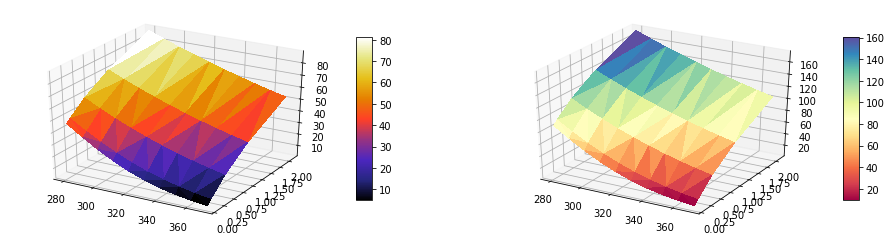

In [252]:
graph_option_subplot(chains_blackscholes, chains_extension, portfolio[1])

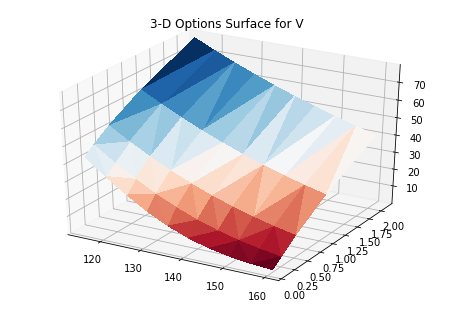

In [254]:
graph_option_1(chains_extension, portfolio[3])

In [81]:
strikes = tradier.get_option_strikes(portfolio[0], t_exp[0])

In [258]:
chain_realtime = pd.DataFrame(columns = ['ask','bid', 'strike', 'underlying', 'volume', 'expiration_date', 'option_type'])
for stock in portfolio: 
    for t in t_exp[stock]: 
        temp = tradier.get_option_chain(stock, t, "pandas")
        temp = temp[temp['strike'].isin(strikes[stock])]
        temp = temp[['ask','bid', 'strike', 'underlying', 'volume', 'expiration_date', 'option_type']]
        chain_realtime = pd.concat([chain_realtime,temp])
chain_realtime.reset_index()

,index,ask,bid,strike,underlying,volume,expiration_date,option_type
0,0,1.98,1.92,105.0,MSFT,3563,2019-01-18,put
1,3,0.23,0.21,90.0,MSFT,62,2019-01-18,put
2,4,15.25,14.95,95.0,MSFT,42,2019-01-18,call
3,5,6.75,6.50,105.0,MSFT,613,2019-01-18,call
4,7,0.96,0.92,100.0,MSFT,934,2019-01-18,put
5,10,0.12,0.09,85.0,MSFT,214,2019-01-18,put
6,12,20.10,19.70,90.0,MSFT,20,2019-01-18,call
7,13,10.75,10.45,100.0,MSFT,123,2019-01-18,call
8,17,25.05,24.30,85.0,MSFT,0,2019-01-18,call
9,42,20.95,20.40,130.0,MSFT,0,2019-01-18,put


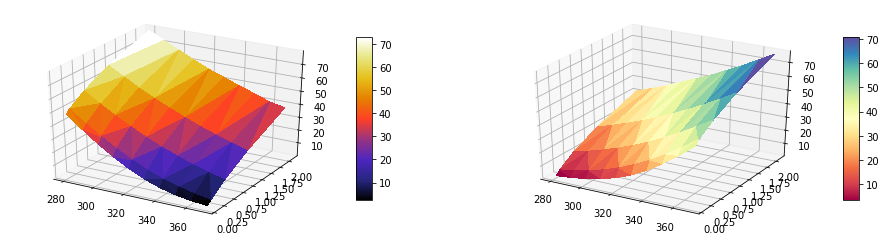

In [287]:
graph_real_option_subplot(chain_realtime, portfolio[1])

In [304]:
temp = chain_realtime[((chain_realtime['underlying'] == stock) & (chain_realtime['option_type'] == 'call'))]
surface = go.Surface(x=temp["strike"], y=temp["T"], z=temp["Spread"])
data = [surface]

layout = go.Layout(
    title='Parametric Plot',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Realtime options call data on MSFT')